In [52]:
!pip install keras

In [53]:
!pip install tensorflow

In [54]:
# Read the data
train = pd.read_csv('train.csv')
#train = data[0:2000]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [55]:
import sklearn
import numpy as np
import re
import string
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def preprocess(corpus):
    # Create a set of stopwords
    stopwords_english = set(stopwords.words('english'))

    cleaned_corpus = []
    for text in corpus:
        # Lowercase
        text = text.lower()
        # Remove links
        text = re.sub(r'https?://[^\s\n\r]+', '', text)
        # Remove punctuation
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        # Remove words containing numbers
        text = re.sub(r'\w*\d\w*', '', text)
        # Tokenize and remove stopwords
        words = text.split()
        words = [word for word in words if word not in stopwords_english]
        cleaned_corpus.append(' '.join(words))
    return cleaned_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
X = train['comment_text']
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [88]:
samples = 10000

toxic_indices = y[y['toxic'] == 1].index
random_toxic_indices = np.random.choice(toxic_indices, samples, replace=True)
non_toxic_indices = y[y['toxic'] == 0].index
random_non_toxic_indices = np.random.choice(non_toxic_indices, samples, replace=True)


severe_toxic_indices = y[y['severe_toxic'] == 1].index
random_severe_toxic_indices = np.random.choice(severe_toxic_indices, samples, replace=True)
non_severe_toxic_indices = y[y['toxic'] == 0].index
random_non_severe_toxic_indices = np.random.choice(non_toxic_indices, samples, replace=True)


obscene_indices = y[y['obscene'] == 1].index
random_obscene_indices = np.random.choice(obscene_indices, samples, replace=True)
non_obscene_indices = y[y['toxic'] == 0].index
random_non_obscene_indices = np.random.choice(non_toxic_indices, samples, replace=True)


threat_indices = y[y['threat'] == 1].index
random_threat_indices = np.random.choice(threat_indices, samples, replace=True)
non_threat_indices = y[y['toxic'] == 0].index
random_non_threat_indices = np.random.choice(non_toxic_indices, samples, replace=True)

insult_indices = y[y['insult'] == 1].index
random_insult_indices = np.random.choice(insult_indices, samples, replace=True)
non_insult_indices = y[y['toxic'] == 0].index
random_non_insult_indices = np.random.choice(non_toxic_indices, samples, replace=True)

identity_hate_indices = y[y['identity_hate'] == 1].index
random_identity_hate_indices = np.random.choice(identity_hate_indices, samples, replace=True)
non_identity_hate_indices = y[y['toxic'] == 0].index
random_non_identity_hate_indices = np.random.choice(non_toxic_indices, samples, replace=True)

new_indices = np.concatenate([
    random_toxic_indices,
    random_severe_toxic_indices,
    random_obscene_indices,
    random_threat_indices,
    random_insult_indices,
    random_identity_hate_indices,
    random_non_toxic_indices,
    random_non_severe_toxic_indices,
    random_non_obscene_indices,
    random_non_threat_indices,
    random_non_insult_indices,
    random_non_identity_hate_indices
])

# Subset the data with resampled indices
X_sampled = X[new_indices]
y_sampled = y.iloc[new_indices]

In [83]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_sampled)
X_seq = tokenizer.texts_to_sequences(X_sampled)
max_length = 200
X_padded = pad_sequences(X_seq, maxlen=max_length)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_sampled, test_size=0.2, random_state=42)

# Build LSTM model
embedding_dim = 100
#units = 100  # You can adjust the number of LSTM units based on your needs

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5, seed=1))
model.add(Dense(6, activation='softmax'))

custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=custom_optimizer, 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.AUC(name='auc-roc')])



In [85]:
# Train the model
batch_num = 128
epochs = 5
opt = model.fit(X_train, y_train, batch_size=batch_num, epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/5
750/750 [==============================] - 157s 210ms/step - loss: 0.0921 - accuracy: 0.9041 - precision_5: 0.4953 - recall_5: 0.2825 - auc-roc: 0.6627 - val_loss: 0.0810 - val_accuracy: 0.9327 - val_precision_5: 0.4929 - val_recall_5: 0.2909 - val_auc-roc: 0.6893
Epoch 2/5
750/750 [==============================] - 163s 217ms/step - loss: 0.0661 - accuracy: 0.9157 - precision_5: 0.4841 - recall_5: 0.2861 - auc-roc: 0.6752 - val_loss: 0.0685 - val_accuracy: 0.9282 - val_precision_5: 0.4949 - val_recall_5: 0.2901 - val_auc-roc: 0.6931
Epoch 3/5
750/750 [==============================] - 163s 217ms/step - loss: 0.0529 - accuracy: 0.9008 - precision_5: 0.4859 - recall_5: 0.2870 - auc-roc: 0.6740 - val_loss: 0.0605 - val_accuracy: 0.9398 - val_precision_5: 0.4993 - val_recall_5: 0.2920 - val_auc-roc: 0.6694
Epoch 4/5
750/750 [==============================] - 162s 216ms/step - loss: 0.0405 - accuracy: 0.8802 - precision_5: 0.4896 - recall_5: 0.2902 - auc-roc: 0.6780 - val_loss: 0

In [61]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

998/998 [==============================] - 24s 24ms/step - loss: 0.1420 - accuracy: 0.9941
Validation Loss: 0.14196115732192993, Validation Accuracy: 0.9941093325614929


In [62]:
# Make predictions on test data
test = pd.read_csv('test.csv')
clean_test_comments = preprocess(test['comment_text'])
X_test_seq = tokenizer.texts_to_sequences(clean_test_comments)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)


In [89]:
predictions = model.predict(X_test_padded)
# Create a submission file
subm = pd.read_csv('sample_submission.csv')
subm[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = predictions
subm.to_csv('rnn_submission.csv', index=False)


4787/4787 [==============================] - 179s 37ms/step


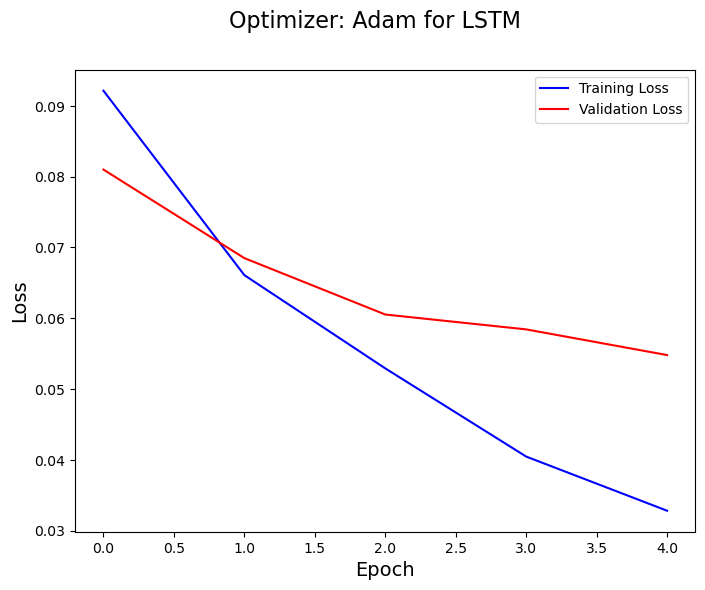

In [90]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.suptitle('Optimizer: Adam for LSTM', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.plot(opt.history['loss'], color='b', label='Training Loss')
plt.plot(opt.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()